In [1]:
from preprocessing_utils import load_all_files, preprocess_documents
from pathlib import Path
import os
from api import GOOGLE_API_KEY
import google.generativeai as genai
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
genai.configure(api_key=GOOGLE_API_KEY)

c:\Users\mikel\Documents\GitHub\multimodal-rag\.venv\Lib\site-packages\deepeval\__init__.py:54: UserWarning: You are using deepeval version 2.7.1, however version 2.7.5 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


## Text only

In [ ]:
papers_path = Path("papers/selection")
docs = load_all_files(papers_path)
docs = preprocess_documents(docs) 

In [2]:
from langchain_core.prompts import PromptTemplate

template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use around three sentences for your answer and keep it concise.
Do not ever mention that you are using the context as source.

Question: {question}

Context:
{context}

Answer:"    
"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [3]:
# from langchain import hub
# from langchain_chroma import Chroma
from qdrant_client import QdrantClient
from langchain_qdrant import QdrantVectorStore
from qdrant_client import models
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

GENERATIVE_MODEL_NAME = "gemini-2.0-flash-lite"
EMBEDDINGS_MODEL_NAME = "models/text-embedding-004"

qdrant_client = QdrantClient(path="papers_db")
#### UNCOMMENT IF CREATING COLLECTION FROM SCRATCH
# qdrant_client.create_collection(
#     collection_name="selection",
#     vectors_config=models.VectorParams(
#         size=768,
#         distance=models.Distance.COSINE
#     )

# )
embeddings = GoogleGenerativeAIEmbeddings(model=EMBEDDINGS_MODEL_NAME)
vectorstore = QdrantVectorStore(
    client=qdrant_client,
    collection_name="selection",
    embedding=embeddings,
    distance=models.Distance.COSINE
)
#### UNCOMMENT IF CREATING COLLECTION FROM SCRATCH
# vectorstore.add_documents(docs)

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever(
    search_kwargs={"k": 3}
)
llm = ChatGoogleGenerativeAI(model=GENERATIVE_MODEL_NAME)
prompt = custom_rag_prompt


def format_docs(docs):
    """Concatenates doc contents into a single string.

    Parameters
    ----------
    docs : list
        list of Document objects

    Returns
    -------
    str
        doc page_contents concatenated into a string
    """
    return "\n\n".join(doc.page_content for doc in docs)

system_prompt = (
    "You are an assistant for question-answering tasks."
    "Use the following pieces of retrieved context to answer the question."
    "If you don't know the answer, just say that you don't know."
    "Use around three sentences for your answer and keep it concise."
    "Use LaTeX to format any math equation."
    "Do not ever mention that you are using the context as source."
    "Here is context for your answer:"
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [4]:
response = rag_chain.invoke({"input":
"Give me an example architecture of a graph neural network used to predict physical properties of crystals and describe the internal architecture."
                             })
print(response["context"])
print(response["answer"])

[Document(metadata={'producer': 'iText® 5.3.5 ©2000-2012 1T3XT BVBA (SPRINGER SBM; licensed version)', 'creator': 'Springer', 'creationdate': '2021-08-31T00:12:39+05:30', 'keywords': '', 'crossmarkdomains[1]': 'springer.com', 'moddate': '2021-08-31T07:48:08+02:00', 'subject': 'Communications Materials, doi:10.1038/s43246-021-00194-3', 'doi': '10.1038/s43246-021-00194-3', 'author': 'Jiucheng Cheng', 'crossmarkdomains[2]': 'springerlink.com', 'title': 'A geometric-information-enhanced crystal graph network for predicting properties of materials', 'source': 'papers/selection/Cheng et al. - 2021 - A geometric-information-enhanced crystal graph net.pdf', 'total_pages': 11, 'page': 1, 'page_label': '2', '_id': '36825661a76a4aec975a0d94df1f33c1', '_collection_name': 'selection'}, page_content='aggregation process. In material prediction domain, the geometrical Crystal graph deﬁ nition and the introduction of geometric\nstructure information like spatial distance and direction is alsoinformati

In [4]:
from preprocessing_utils import load_queries, load_answers

queries = load_queries("papers/selection_queries.txt")
answers = load_answers("papers/selection_answers.txt")

In [6]:
paper_names = sorted(os.listdir("papers/selection"), key=lambda x: int(x.split("_")[0]))
paper_names

['1_helical_weyl.pdf',
 '2_magic_angle.pdf',
 '3_chiral_kagome.pdf',
 '4_quantum_supremacy.pdf',
 '5_wte2.pdf',
 '6_fgt.pdf',
 '7_kagome_order.pdf',
 '8_triangulene.pdf',
 '9_neutron_activation.pdf',
 '10_rucl3.pdf',
 '11_methylammonium.pdf',
 '12_perovskites.pdf',
 '13_high_troughput.pdf',
 '14_quenched_nematic.pdf',
 '15_fractional_charges.pdf',
 '16_plasmons.pdf',
 '17_charge_transfer.pdf',
 '18_photonic_axion.pdf',
 '19_adsorption.pdf',
 '20_cgnn.pdf']

In [ ]:
doc_max_page = {}
for doc in docs:
    doc_max_page[Path(doc.metadata["source"]).name] = doc.metadata["total_pages"]

doc_max_page

{'10_rucl3.pdf': 12,
 '11_methylammonium.pdf': 7,
 '12_perovskites.pdf': 13,
 '13_high_troughput.pdf': 9,
 '14_quenched_nematic.pdf': 7,
 '15_fractional_charges.pdf': 20,
 '16_plasmons.pdf': 14,
 '17_charge_transfer.pdf': 11,
 '18_photonic_axion.pdf': 12,
 '19_adsorption.pdf': 10,
 '1_helical_weyl.pdf': 10,
 '20_cgnn.pdf': 11,
 '2_magic_angle.pdf': 13,
 '3_chiral_kagome.pdf': 19,
 '4_quantum_supremacy.pdf': 7,
 '5_wte2.pdf': 6,
 '6_fgt.pdf': 10,
 '7_kagome_order.pdf': 7,
 '8_triangulene.pdf': 6,
 '9_neutron_activation.pdf': 8}

In [28]:
qrel = {}
query_index = 1

for group_index, questions in enumerate(queries):
    for query in questions:
        query_dict = qrel.setdefault(f"q{query_index}", {})
        query_index += 1
        for doc_index, doc_name in enumerate(paper_names):
            for page_num in range(doc_max_page[doc_name]):
                query_dict[f"{doc_name}_{page_num + 1}"] = 1 if group_index == doc_index else 0

In [29]:
run = {}
query_index = 1
for questions, gold_name in zip(queries, paper_names):
    for query in questions:
        query_dict = run.setdefault(f"q{query_index}", {})
        query_index += 1
        result = vectorstore.similarity_search_with_score(query, k=1e6)
        for point, score in result:
            doc_name = Path(point.metadata["source"]).name
            page_num = point.metadata["page"]
            query_dict[f"{doc_name}_{page_num+1}"] = score

In [30]:
import json

json.dump(run, open("run_text.json", "w"), indent=4)

## Multimodal

In [ ]:
llm = ChatGoogleGenerativeAI(model=GENERATIVE_MODEL_NAME)

In [ ]:
from multimodal_rag.rag_model import QdrantMultiModalRetriever
from multimodal_rag.vlm import VLM

VLM_MODEL = "vidore/colqwen2.5-v0.2"

vlm = VLM.from_pretrained(
    VLM_MODEL,
    device="cuda:0",
    pool_factor=0
)

IMAGE_FOLDER = Path("images/selection")

rag = QdrantMultiModalRetriever(vlm, qdrant_client, save_docs_path=IMAGE_FOLDER)
rag.create_collection("selection")
rag.collection

In [ ]:
rag.save_from_folder("papers/selection")

In [ ]:
from langchain.prompts import ChatPromptTemplate 
import base64
from langchain_core.runnables import RunnableLambda 
from langchain_google_genai import ChatGoogleGenerativeAI


llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite")

top_k = 3

# Folder for page images.
IMAGE_FOLDER = Path("images/selection")

def encode_image(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode("utf-8")

def load_image_from_point(point):
    image_path = IMAGE_FOLDER / f"{point.id}.jpg"
    return encode_image(image_path)

def retrieve_points(query, limit=10, top_k=3):
    result = rag.search(
        query,
        limit=limit
    )
    return result.points[:top_k]

def retrieve_images(query, limit=10, top_k=3):
    result = rag.search(
        query,
        limit=limit
    )

    images = []
    for point in result.points[:top_k]:
        images.append(load_image_from_point(point))

    return images

def expand_context_images(message):
    new_message = {}
    new_message["query"] = message["query"]
    for i, image in enumerate(message["context_images"]):
        new_message[f"context{i}"] = image
    
    return new_message

system_message = (
    "You are an assistant for question-answering tasks."
    "Use the images of retrieved context to answer the question."
    "If you don't know the answer, just say that you don't know."
    "Use around three sentences for your answer and keep it concise."
    "Use LaTeX to format any math equation."
    "Do not ever mention that you are using the context as source."
) 

user_message = [
    {
        "type": "text",
        "text": "{query}",
    }
] + [
    {
        "type": "image_url",
        "image_url": {"url": "data:image/jpeg;base64,{placeholder}".replace("placeholder", f"context{i}")},
    }
    for i in range(top_k)
]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_message),
        (
            "user",
            user_message,
        ),
    ]
)
rag_chain = (
    {"context_images": retrieve_images, "query": RunnablePassthrough()}
    | RunnableLambda(expand_context_images)
    | prompt
    | llm
    | StrOutputParser()
)

/var/folders/9w/3l6rxjcs3bgfl3v7b2f66llr0000gn/T/ipykernel_77878/2457562682.py:44: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm(formatted_prompt)


The image features a tabby cat wearing orange sunglasses. The cat has green eyes and a white chest. It's sitting on what appears to be a sofa, with various cushions visible in the background. The image is well-lit and has a shallow depth of field, focusing attention on the cat's face.


In [42]:
prompt

ChatPromptTemplate(input_variables=['context0', 'context1', 'query'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks.Use the images of retrieved context to answer the question.If you don't know the answer, just say that you don't know.Use around three sentences for your answer and keep it concise.Do not ever mention that you are using the context as source."), additional_kwargs={}), HumanMessagePromptTemplate(prompt=[PromptTemplate(input_variables=['query'], input_types={}, partial_variables={}, template='{query}'), ImagePromptTemplate(input_variables=['context0'], input_types={}, partial_variables={}, template={'url': 'data:image/jpeg;base64,{context0}'}), ImagePromptTemplate(input_variables=['context1'], input_types={}, partial_variables={}, template={'url': 'data:image/jpeg;base64,{context1}'})], additional_kwargs={}

## Mixed pipeline

In [ ]:
from langchain_community.document_loaders import PyPDFLoader
def load_docs_as_dict(root_path, mode="page"):
    """Loads PDF documents into a dictionary indexed by their name where
    each value is a list of Document objects, one for each page

    Parameters
    ----------
    root_path : str | Path
        path where the PDF documents are
    mode : str, optional
        how to chunk the documents, by default "page"

    Returns
    -------
    dict
        document dictionary
    """
    docs = {}
    num_files = 0
    for path, folders, files in os.walk(root_path):
        path = Path(path)
        if len(folders) != 0:
            continue
        for file in files:
            if not file.endswith(".pdf"):
                continue
            doc_loader = PyPDFLoader(path / file, mode=mode, extraction_mode="layout")
            pages = preprocess_documents(doc_loader.load())
            docs.setdefault(file, pages)
            num_files += 1
            print(f"Number of files: {num_files}")

    return docs

In [ ]:
docs_dict = load_docs_as_dict(Path("papers/selection"))

In [ ]:
llm = ChatGoogleGenerativeAI(model=GENERATIVE_MODEL_NAME)

top_k = 3

def retrieve_text(query, limit=10, top_k=3):
    result = rag.search(
        query,
        limit=limit
    )

    doc_text = []
    for point in result.points[:top_k]:
        doc_name = point.payload["doc_name"]
        page_num = point.payload["page_num"]
        doc_text.append(docs_dict[doc_name][page_num - 1].page_content)

    return "\n\n".join(doc_text)

template = (
    "You are an assistant for question-answering tasks."
    "Use the following pieces of retrieved context to answer the question."
    "If you don't know the answer, just say that you don't know."
    "Use around three sentences for your answer and keep it concise."
    "Use LaTeX to format any math equation."
    "Do not ever mention that you are using the context as source."
    "Here is the question:\n"
    "{query}\n"
    "Here is context for your answer:"
    "\n\n"
    "{context}"
    "\n\n"
    "Answer:"
) 

prompt = PromptTemplate.from_template(template)

rag_chain = (
     {"context": retrieve_text, "query": RunnablePassthrough()}
     | prompt
     | llm
     | StrOutputParser()
)

## Evaluation

In [5]:
from preprocessing_utils import load_queries, load_answers

queries = load_queries("papers/selection_queries.txt")
answers = load_answers("papers/selection_answers.txt")

### Retrieval

Create `trec_eval` gold and generated items.

In [ ]:
paper_names = sorted(os.listdir("papers/selection"), key=lambda x: int(x.split("_")[0]))

# Get max number of pages per document
doc_max_page = {}
for record in rag.list_items(limit=1000):
    doc_max_page.setdefault(record.payload["doc_name"], 1)
    page_num = record.payload["page_num"]
    if page_num > doc_max_page[record.payload["doc_name"]]:
        doc_max_page[record.payload["doc_name"]] = page_num
doc_max_page

# qrel holds goldens for retrieval
qrel = {}
query_index = 1

for group_index, questions in enumerate(queries):
    for query in questions:
        query_dict = qrel.setdefault(f"q{query_index}", {})
        query_index += 1
        for doc_index, doc_name in enumerate(paper_names):
            for page_num in range(doc_max_page[doc_name]):
                query_dict[f"{doc_name}_{page_num + 1}"] = 1 if group_index == doc_index else 0

query_index = 1
# run holds pipeline retrievals
run = {}
for questions, gold_name in zip(queries, paper_names):
    for query in questions:
        # use VLM retriever or text retriever
        result = rag.search(query, limit=1e6)
        query_dict = run.setdefault(f"q{query_index}", {})
        query_index += 1
        for point in result.points:
            doc_name = point.payload["doc_name"]
            page_num = point.payload["page_num"]
            query_dict[f"{doc_name}_{page_num}"] = point.score

run     

In [ ]:
from pytrec_eval import RelevanceEvaluator
import json

evaluator = RelevanceEvaluator(qrel, {"ndcg", "ndcg_cut_3", "ndcg_cut_5"})
evaluation = evaluator.evaluate(run)
json.dump(evaluation, open("ndcg_vlm.json", 'w'), indent=4)
evaluation

### Generation

In [8]:
from deepeval.dataset import EvaluationDataset
from preprocessing_utils import create_dataset


dataset = create_dataset(rag_chain, queries, answers)

Sleeping after 15 queries
Resuming
Sleeping after 15 queries
Resuming
Sleeping after 15 queries
Resuming
Sleeping after 15 queries
Resuming


In [9]:
dataset.save_as(file_type="json", directory="papers/selection_gemini-2.0-flash-lite_text", include_test_cases=True)

Evaluation dataset saved at papers/selection_gemini-2.0-flash-lite_text\20250413_122238.json!


'papers/selection_gemini-2.0-flash-lite_text\\20250413_122238.json'

In [6]:
from deepeval.dataset import EvaluationDataset

DATASET_PATH = Path(r"papers\results\selection_gemini-2.0-flash_vlm\20250413_102955.json")
dataset = EvaluationDataset()
dataset.add_test_cases_from_json_file(
    file_path=DATASET_PATH,
    input_key_name="input",
    actual_output_key_name="actual_output",
    expected_output_key_name="expected_output",
    context_key_name="context",
    retrieval_context_key_name="retrieval_context",
)

In [ ]:
from deepeval.metrics import AnswerRelevancyMetric
from deepeval.models.llms import GeminiModel
from deepeval import evaluate
from time import sleep

judge_llm = GeminiModel(
    model_name="gemini-2.0-flash-lite",
    api_key=GOOGLE_API_KEY
)

answer_relevancy_metric = AnswerRelevancyMetric(threshold=0.5, model=judge_llm, include_reason=True)

# Evaluate by batches to not saturate Google Generative AI free quota

results = []
batch_size = 5
test_case_index = 0
number_errors = 0
for i, test_case in enumerate(dataset.test_cases):
    try:
        result = evaluate(test_cases=[test_case], metrics=[answer_relevancy_metric])
    except AttributeError:
        print("Error in test case:", i)
        print("Continuing...")
        number_errors += 1
    results.append(result)
    if (i + 1) % batch_size == 0:
        print("Processed", i + 1, " test cases")
        sleep(65)

print(number_errors)


In [8]:
import pickle
pickle.dump(results, open(DATASET_PATH.parent / "answer_relevancy.pkl", "wb"))

Smiliarity with cosine distance between expected and actual answers

In [3]:
from tqdm import tqdm
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
EMBEDDINGS_MODEL_NAME = "models/text-embedding-004"
embeddings = GoogleGenerativeAIEmbeddings(model=EMBEDDINGS_MODEL_NAME)

actual_embeddings = []
expected_embeddings = []
for test_case in tqdm(dataset.test_cases):
    actual_vector = embeddings.embed_query(test_case.actual_output)
    actual_embeddings.append(actual_vector)
    expected_vector = embeddings.embed_query(test_case.expected_output)
    expected_embeddings.append(expected_vector)

100%|██████████| 60/60 [00:28<00:00,  2.12it/s]


In [4]:
import numpy as np
from metrics import similarity_scores

scores = similarity_scores(actual_embeddings, expected_embeddings)

In [9]:
np.savetxt(DATASET_PATH.parent / "similarity_scores.dat", scores)

## Intepreting results

In [227]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="darkgrid")

### Retrieval

In [235]:
df = pd.read_json("papers/results/ncdg_text.json").T.reset_index()
df.head()

,index,ndcg,ndcg_cut_3,ndcg_cut_5
0,q1,0.991962,1.0,1.000000
1,q2,0.997772,1.0,1.000000
2,q3,1.000000,1.0,1.000000
3,q4,0.936568,1.0,0.868795
4,q5,0.968682,1.0,1.000000


In [240]:
df["index"].str.replace("q", "")

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
25    26
26    27
27    28
28    29
29    30
30    31
31    32
32    33
33    34
34    35
35    36
36    37
37    38
38    39
39    40
40    41
41    42
42    43
43    44
44    45
45    46
46    47
47    48
48    49
49    50
50    51
51    52
52    53
53    54
54    55
55    56
56    57
57    58
58    59
59    60
Name: index, dtype: object

In [253]:
import json
def load_retrieval_results(file_path):
    df = pd.read_json(file_path).T.reset_index()
    df["query_number"] = df["index"].str.replace("q", "").astype(int)
    df = df.drop(columns=["index"])
    return df

text_df = load_retrieval_results("papers/results/ndcg_text.json")
text_df["model"] = "text"
vlm_df = load_retrieval_results("papers/results/ndcg_vlm.json")
vlm_df["model"] = "vlm"
retrieval_df = pd.concat([text_df, vlm_df], ignore_index=True)
retrieval_df.head()

,ndcg,ndcg_cut_3,ndcg_cut_5,query_number,model
0,0.991962,1.0,1.000000,1,text
1,0.997772,1.0,1.000000,2,text
2,1.000000,1.0,1.000000,3,text
3,0.936568,1.0,0.868795,4,text
4,0.968682,1.0,1.000000,5,text


(0.8, 1.0)

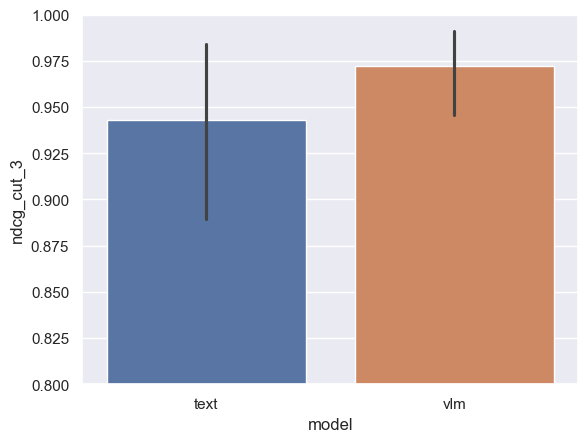

In [256]:
sns.barplot(
    data=retrieval_df,
    x="model",
    y="ndcg_cut_3",
    hue="model",
    estimator=np.mean,
    errorbar="ci"
)

plt.ylim(0.8, 1.0)

(0.8, 1.0)

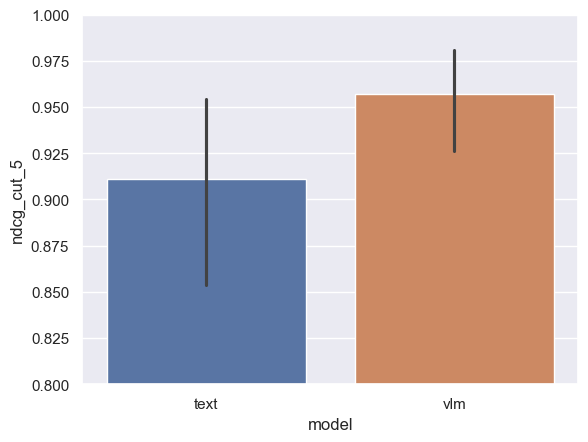

In [260]:
sns.barplot(
    data=retrieval_df,
    x="model",
    y="ndcg_cut_5",
    hue="model",
    estimator=np.mean,
    errorbar="ci"
)

plt.ylim(0.8, 1.0)

(0.8, 1.0)

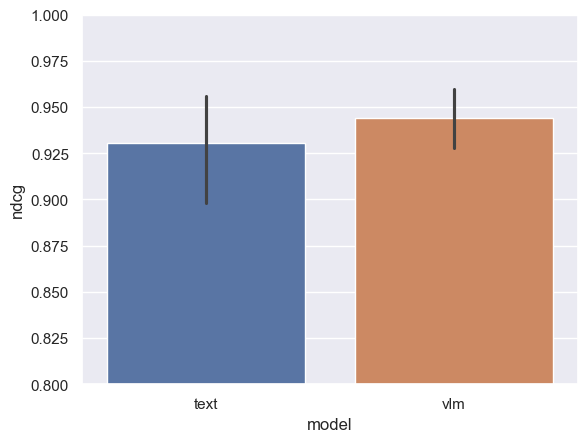

In [258]:
sns.barplot(
    data=retrieval_df,
    x="model",
    y="ndcg",
    hue="model",
    estimator=np.mean,
    errorbar="ci"
)

plt.ylim(0.8, 1.0)

### Generation

In [ ]:
from pathlib import Path
names = ["text", "vlm", "mixed", "text-lite", "vlm-lite", "mixed-lite"]
paths = [
    "papers/results/selection_gemini-2.0-flash_text",
    "papers/results/selection_gemini-2.0-flash_vlm",
    "papers/results/selection_gemini-2.0-flash_mixed",
    "papers/results/selection_gemini-2.0-flash-lite_text",
    "papers/results/selection_gemini-2.0-flash-lite_vlm",
    "papers/results/selection_gemini-2.0-flash-lite_mixed",
]

scores = {}
for name, path in zip(names, paths):
    scores.setdefault(name, np.loadtxt(Path(path) / "similarity_scores.dat"))

In [81]:
import pandas as pd
scores_df = pd.DataFrame(scores)
scores_df["query_number"] = [i for i in range(1, len(scores_df) + 1)]
scores_df = scores_df.melt(id_vars=["query_number"], var_name="model", value_name="similarity")
scores_df.head()

,query_number,model,similarity
0,1,text,0.820107
1,2,text,0.933743
2,3,text,0.890277
3,4,text,0.873196
4,5,text,0.814583


In [162]:
def load_answers_dataset(root, name_filter=None):
    dataframes = []
    if name_filter is None:
        name_filter = "selection_gemini-2.0-flash"
    
    root = Path(root)
    for path, folders, files in root.walk():
        if len(folders) != 0:
            continue
        if name_filter not in path.name:
            continue
        for file in files:
            if not file.endswith(".json"):
                continue
            dataset = pd.read_json(path / file).drop(columns=["retrieval_context", "context", "source_file"])
            dataset["query_number"] = [i for i in range(1, len(dataset) + 1)]
            model_name = path.name.split("_")[-1]
            model_name = model_name + "-lite" if "lite" in path.name else model_name
            dataset["model"] = [model_name for _ in range(len(dataset))]

            dataframes.append(dataset)
    return pd.concat(dataframes, ignore_index=True)

answers_df = load_answers_dataset("papers/results", None)

In [ ]:
generation_df = pd.merge(
    scores_df,
    answers_df,
    on=["query_number", "model"],
    how="inner"
)
generation_df.head()

,query_number,model,similarity,input,actual_output,expected_output
0,1,text,0.820107,What crystal magnetic structure does EuCuAs have?,EuCuAs has a planar helix magnetic structure w...,EuCuAs is described by the centrosymmetric P63...
1,2,text,0.933743,What are the estimated exchange parameters for...,The estimated exchange parameters for EuCuAs a...,The estimated exchange and anisotropy paramete...
2,3,text,0.890277,Can the magnetic behavior of EuCuAs be describ...,"Yes, the magnetic behavior of EuCuAs can be de...","Yes, the magnetic behavior of EuCuAs can be de..."
3,4,text,0.873196,How is the superconductivity measured in a gra...,Superconductivity in a twisted bilayer graphen...,Superconductivity is measured using a four-pro...
4,5,text,0.814583,"Explain what is the interplay between metal, M...","In magic-angle twisted bilayer graphene (TBG),...","In magic-angle TBG, superconductivity is achie..."


In [202]:
import pickle
def process_evaluation_run(run):
    results = {
        "inputs": [],
        "actual_outputs": [],
        "expected_outputs": [],
        "score": [],
        "success": [],
        "reason": []
    }
    for batch in run:
        for test_result in batch.test_results:
            results["inputs"].append(test_result.input)
            results["actual_outputs"].append(test_result.actual_output)
            results["expected_outputs"].append(test_result.expected_output)
            metrics_data = test_result.metrics_data[0]
            results["success"].append(metrics_data.success)
            results["reason"].append(metrics_data.reason)
            results["score"].append(metrics_data.score)
    results = pd.DataFrame(results)
    results["query_number"] = [i for i in range(1, len(results) + 1)]
    return results

def load_relevancy_dataset(root, name_filter=None):
    dataframes = []
    if name_filter is None:
        name_filter = "selection_gemini-2.0-flash"
    
    root = Path(root)
    for path, folders, files in root.walk():
        if len(folders) != 0:
            continue
        if name_filter not in path.name:
            continue
        for file in files:
            if not file.endswith(".pkl"):
                continue
            
            dataset = process_evaluation_run(
                pickle.load(open(path / file, "rb"))
            )
            model_name = path.name.split("_")[-1]
            model_name = model_name + "-lite" if "lite" in path.name else model_name
            dataset["model"] = [model_name for _ in range(len(dataset))]

            dataframes.append(dataset)
    return pd.concat(dataframes, ignore_index=True)

relevancy_df = load_relevancy_dataset("papers/results", None)
relevancy_df.head()

,inputs,actual_outputs,expected_outputs,score,success,reason,query_number,model
0,What crystal magnetic structure does EuCuAs have?,EuCuAs exhibits a helical spin arrangement in ...,EuCuAs is described by the centrosymmetric P63...,1.0,True,The score is 1.00 because the output perfectly...,1,mixed-lite
1,What are the estimated exchange parameters for...,The estimated exchange parameters for EuCuAs a...,The estimated exchange and anisotropy paramete...,1.0,True,The score is 1.00 because the output perfectly...,2,mixed-lite
2,Can the magnetic behavior of EuCuAs be describ...,"Yes, the magnetic behavior of EuCuAs can be de...","Yes, the magnetic behavior of EuCuAs can be de...",1.0,True,The score is 1.00 because the output perfectly...,3,mixed-lite
3,How is the superconductivity measured in a gra...,Superconductivity in graphene superlattices is...,Superconductivity is measured using a four-pro...,1.0,True,The score is 1.00 because the output is perfec...,4,mixed-lite
4,"Explain what is the interplay between metal, M...","In magic-angle TBG, the interplay between meta...","In magic-angle TBG, superconductivity is achie...",1.0,True,The score is 1.00 because the output perfectly...,5,mixed-lite


In [ ]:
generation_df = pd.merge(
    generation_df,
    relevancy_df,
    on=["query_number", "model"],
    how="inner"
)

generation_df.head()

,query_number,model,similarity,input,actual_output,expected_output,inputs,actual_outputs,expected_outputs,score,success,reason
0,1,text,0.820107,What crystal magnetic structure does EuCuAs have?,EuCuAs has a planar helix magnetic structure w...,EuCuAs is described by the centrosymmetric P63...,What crystal magnetic structure does EuCuAs have?,EuCuAs has a planar helix magnetic structure w...,EuCuAs is described by the centrosymmetric P63...,1.0,True,The score is 1.00 because the output perfectly...
1,2,text,0.933743,What are the estimated exchange parameters for...,The estimated exchange parameters for EuCuAs a...,The estimated exchange and anisotropy paramete...,How is the superconductivity measured in a gra...,Superconductivity in a twisted bilayer graphen...,Superconductivity is measured using a four-pro...,1.0,True,The score is 1.00 because the output is perfec...
2,3,text,0.890277,Can the magnetic behavior of EuCuAs be describ...,"Yes, the magnetic behavior of EuCuAs can be de...","Yes, the magnetic behavior of EuCuAs can be de...",Can the magnetic behavior of EuCuAs be describ...,"Yes, the magnetic behavior of EuCuAs can be de...","Yes, the magnetic behavior of EuCuAs can be de...",1.0,True,The score is 1.00 because the output perfectly...
3,4,text,0.873196,How is the superconductivity measured in a gra...,Superconductivity in a twisted bilayer graphen...,Superconductivity is measured using a four-pro...,What are the estimated exchange parameters for...,The estimated exchange parameters for EuCuAs a...,The estimated exchange and anisotropy paramete...,1.0,True,The score is 1.00 because the output perfectly...
4,5,text,0.814583,"Explain what is the interplay between metal, M...","In magic-angle twisted bilayer graphene (TBG),...","In magic-angle TBG, superconductivity is achie...","Explain what is the interplay between metal, M...","In magic-angle twisted bilayer graphene (TBG),...","In magic-angle TBG, superconductivity is achie...",1.0,True,The score is 1.00 because the output perfectly...


In [225]:
generation_df = pd.read_csv("papers/results/generation_results.csv")
generation_df.head()

,query_number,model,similarity,input,actual_output,expected_output,inputs,actual_outputs,expected_outputs,score,success,reason
0,1,text,0.820107,What crystal magnetic structure does EuCuAs have?,EuCuAs has a planar helix magnetic structure w...,EuCuAs is described by the centrosymmetric P63...,What crystal magnetic structure does EuCuAs have?,EuCuAs has a planar helix magnetic structure w...,EuCuAs is described by the centrosymmetric P63...,1.0,True,The score is 1.00 because the output perfectly...
1,2,text,0.933743,What are the estimated exchange parameters for...,The estimated exchange parameters for EuCuAs a...,The estimated exchange and anisotropy paramete...,How is the superconductivity measured in a gra...,Superconductivity in a twisted bilayer graphen...,Superconductivity is measured using a four-pro...,1.0,True,The score is 1.00 because the output is perfec...
2,3,text,0.890277,Can the magnetic behavior of EuCuAs be describ...,"Yes, the magnetic behavior of EuCuAs can be de...","Yes, the magnetic behavior of EuCuAs can be de...",Can the magnetic behavior of EuCuAs be describ...,"Yes, the magnetic behavior of EuCuAs can be de...","Yes, the magnetic behavior of EuCuAs can be de...",1.0,True,The score is 1.00 because the output perfectly...
3,4,text,0.873196,How is the superconductivity measured in a gra...,Superconductivity in a twisted bilayer graphen...,Superconductivity is measured using a four-pro...,What are the estimated exchange parameters for...,The estimated exchange parameters for EuCuAs a...,The estimated exchange and anisotropy paramete...,1.0,True,The score is 1.00 because the output perfectly...
4,5,text,0.814583,"Explain what is the interplay between metal, M...","In magic-angle twisted bilayer graphene (TBG),...","In magic-angle TBG, superconductivity is achie...","Explain what is the interplay between metal, M...","In magic-angle twisted bilayer graphene (TBG),...","In magic-angle TBG, superconductivity is achie...",1.0,True,The score is 1.00 because the output perfectly...


<Axes: xlabel='similarity', ylabel='Percent'>

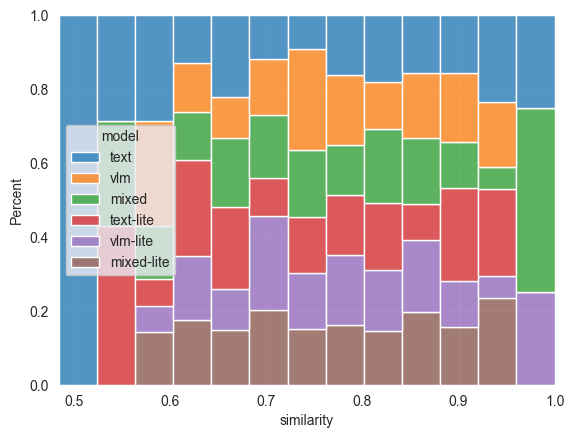

In [226]:
import seaborn as sns

sns.histplot(generation_df, x="similarity", hue="model", stat="percent", common_bins=True,
             multiple="fill")


<Axes: xlabel='model', ylabel='similarity'>

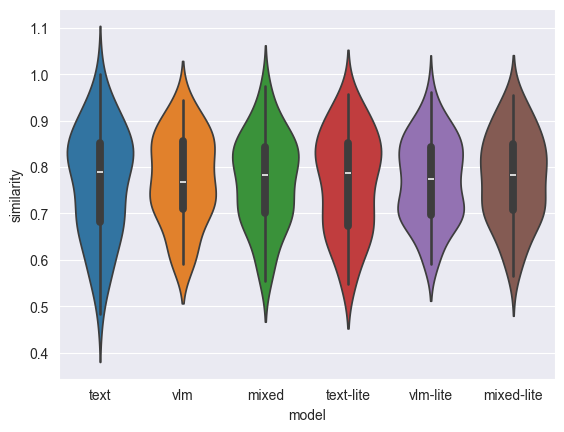

In [ ]:
sns.violinplot(generation_df, y="similarity", hue="model", x="model")

(0.7, 1.0)

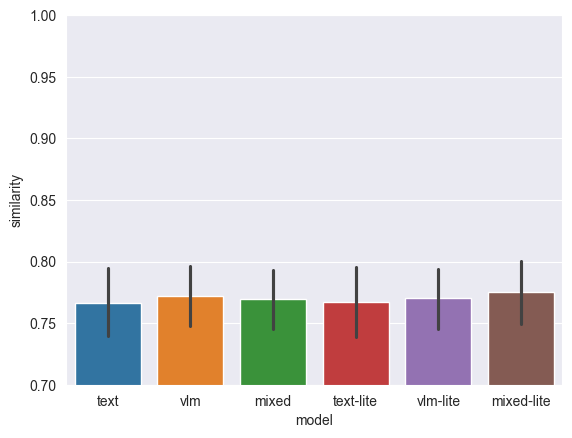

In [ ]:
sns.barplot(generation_df, x="model", y="similarity", hue="model", estimator=np.mean, errorbar="ci")
plt.ylim(0.7, 1.0)

In [ ]:
generation_df.groupby("model").similarity.mean()

model
mixed         0.769691
mixed-lite    0.775280
text          0.766105
text-lite     0.767115
vlm           0.772381
vlm-lite      0.770400
Name: similarity, dtype: float64

<Axes: xlabel='score', ylabel='Percent'>

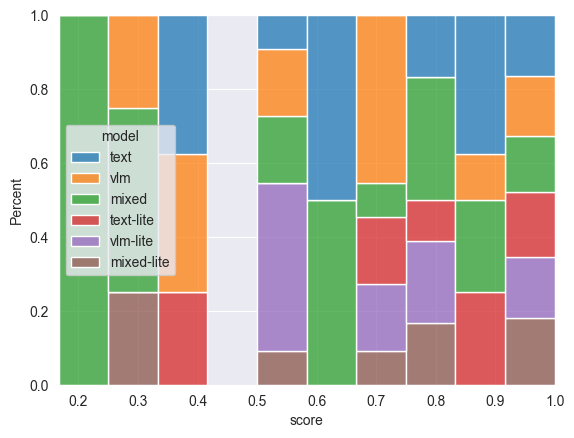

In [ ]:
sns.histplot(generation_df, x="score", hue="model", stat="percent", common_bins=True,
             multiple="fill")

<Axes: xlabel='model', ylabel='score'>

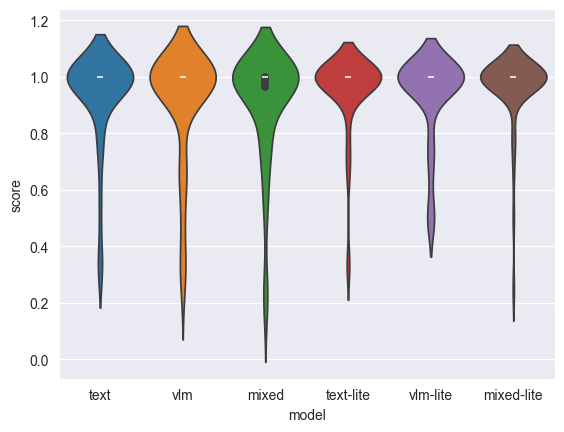

In [ ]:
sns.violinplot(generation_df, y="score", hue="model", x="model")

(0.8, 1.0)

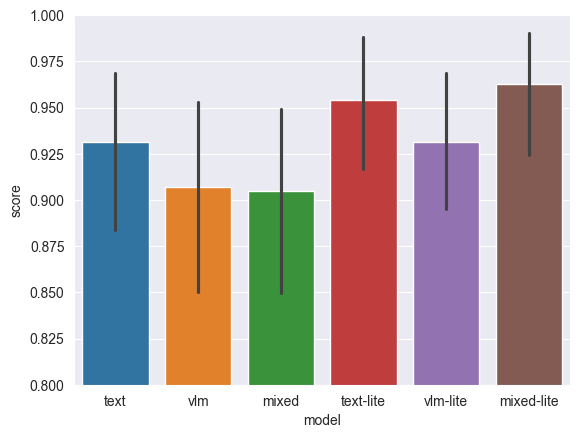

In [ ]:
sns.barplot(generation_df, x="model", y="score", hue="model", estimator=np.mean, errorbar="ci")
plt.ylim(0.8, 1.0)

In [ ]:
generation_df.groupby("model").score.mean()

model
mixed         0.904921
mixed-lite    0.962778
text          0.931230
text-lite     0.953869
vlm           0.906944
vlm-lite      0.931389
Name: score, dtype: float64

In [ ]:
generation_df.groupby("model").success.sum()

model
mixed         57
mixed-lite    59
text          57
text-lite     58
vlm           56
vlm-lite      60
Name: success, dtype: int64